In [1]:
%matplotlib inline

In [2]:
import sklearn
from astropy.io import ascii
from astropy.table import Table
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition
import numpy as np
import seaborn as sns
import pandas as pd

In [3]:
def plot_embedding(X, labels, data, title=None, alpha=None, size=None, color=True):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    
    fig, ax = plt.subplots(1, figsize=(12,12))
    # Colorcode 
    for i in range(X.shape[0]):
        if color:
            ax.scatter(X[i, 0], X[i, 1],
                  color=plt.cm.rainbow_r((labels.iloc[i]+5)/15.), alpha=alpha, s=size)
        else:
            ax.scatter(X[i, 0], X[i, 1], alpha=alpha, s=size, c=1)
    ax.set_xticks([]), ax.set_yticks([])
    if title is not None:
        ax.set_title(title)
    return fig, ax

## Load and prepare data

In [4]:
t_orig = ascii.read("spitzer.s4gcat10163.tbl")
t_orig

object,ra,dec,sma1_25p5,pa1_25p5,ellip1_25p5,mag1,emag1,mag2,emag2,c31_1,c42_1,mabs1,mabs2,mstar,dmean,dstd,t,e_t,vrad,e_vrad,summary
,deg,deg,arcsec,deg,,AB,AB,AB,AB,,,AB,AB,solMass,Mpc,Mpc,,,km / s,km / s,
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str68
NGC4701,192.298304,3.388723,71.4,56.3,0.171,12.233,0.001,12.641,0.002,3.359,3.469,-19.654,-19.246,9.974,23.843,6.093,5.9,0.5,722.8,8.4,"<a href=""/data/SPITZER/S4G/galaxies/NGC4701.html"">Data Access</a>"
NGC4707,192.09555,51.1659,68.1,-0.6,0.159,14.736,0.005,15.511,0.002,1.929,1.803,-14.779,-14.004,8.295,8.0,--,8.8,0.5,467.2,5.5,"<a href=""/data/SPITZER/S4G/galaxies/NGC4707.html"">Data Access</a>"
NGC4710,192.41194,15.165815,176.5,29.2,0.604,10.249,0.001,10.708,0.001,4.114,3.811,-20.878,-20.418,10.501,16.8,--,-0.9,0.8,1100.0,5.5,"<a href=""/data/SPITZER/S4G/galaxies/NGC4710.html"">Data Access</a>"
NGC4713,192.4912,5.311358,83.0,-80.3,0.244,11.803,0.002,12.235,0.003,2.627,2.677,-19.267,-18.835,9.836,16.367,2.399,6.8,0.5,652.7,2.9,"<a href=""/data/SPITZER/S4G/galaxies/NGC4713.html"">Data Access</a>"
NGC4722,192.884862,-13.329981,69.7,33.0,0.565,12.08,0.001,12.564,0.001,3.897,3.753,-19.205,-18.721,9.85,--,--,0.0,0.6,1312.0,9.4,"<a href=""/data/SPITZER/S4G/galaxies/NGC4722.html"">Data Access</a>"
NGC4723,192.76245,-13.23633,41.0,78.7,0.181,14.977,0.031,15.745,0.017,3.09,3.067,-16.295,-15.527,8.896,--,--,8.8,1.1,1302.0,5.5,"<a href=""/data/SPITZER/S4G/galaxies/NGC4723.html"">Data Access</a>"
NGC4725,192.61073,25.500699,346.4,30.5,0.295,8.912,0.001,9.407,0.001,4.342,4.1,-21.762,-21.267,10.881,13.637,2.778,2.2,0.6,1208.5,2.7,"<a href=""/data/SPITZER/S4G/galaxies/NGC4725.html"">Data Access</a>"
NGC4731,192.7551,-6.39352,203.1,84.4,0.579,11.63,0.002,12.053,0.002,3.11,3.093,-19.847,-19.424,10.062,19.75,8.697,5.9,0.5,1492.2,3.1,"<a href=""/data/SPITZER/S4G/galaxies/NGC4731.html"">Data Access</a>"


Determine physical size from angular size and distance. 

In [5]:
arcsec_per_rad = 3600*180.0/np.pi
t_phys = t_orig.copy()
t_phys['phys_size'] = t_phys['sma1_25p5']*t_phys['dmean'] *1e3/arcsec_per_rad
t_phys['phys_size'].unit = "kpc"

Adjust the columns removing not used features and reorder to have labels (*t* column) at the end

In [6]:
t_phys.remove_columns(['dmean', "summary", "ra", "dec", 'dstd', 'sma1_25p5', 'pa1_25p5', 'e_vrad'])#, 'emag1', 'emag2'])
new_order = ["object","ellip1_25p5", "mag1", "emag1", "mag2", "emag2", "c31_1", "c42_1", "mabs1", "mabs2", "mstar", "vrad", "phys_size", "t", "e_t"]
t = t_phys[new_order]
t

object,ellip1_25p5,mag1,emag1,mag2,emag2,c31_1,c42_1,mabs1,mabs2,mstar,vrad,phys_size,t,e_t
,,AB,AB,AB,AB,,,AB,AB,solMass,km / s,kpc,,
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NGC4701,0.171,12.233,0.001,12.641,0.002,3.359,3.469,-19.654,-19.246,9.974,722.8,8.25342059547,5.9,0.5
NGC4707,0.159,14.736,0.005,15.511,0.002,1.929,1.803,-14.779,-14.004,8.295,467.2,2.64126493468,8.8,0.5
NGC4710,0.604,10.249,0.001,10.708,0.001,4.114,3.811,-20.878,-20.418,10.501,1100.0,14.3756952723,-0.9,0.8
NGC4713,0.244,11.803,0.002,12.235,0.003,2.627,2.677,-19.267,-18.835,9.836,652.7,6.58600478054,6.8,0.5
NGC4722,0.565,12.08,0.001,12.564,0.001,3.897,3.753,-19.205,-18.721,9.85,1312.0,--,0.0,0.6
NGC4723,0.181,14.977,0.031,15.745,0.017,3.09,3.067,-16.295,-15.527,8.896,1302.0,--,8.8,1.1
NGC4725,0.295,8.912,0.001,9.407,0.001,4.342,4.1,-21.762,-21.267,10.881,1208.5,22.9019040424,2.2,0.6
NGC4731,0.579,11.63,0.002,12.053,0.002,3.11,3.093,-19.847,-19.424,10.062,1492.2,19.4469675801,5.9,0.5


Labels are from here:

In [7]:
%%HTML
<iframe height="500" width="600" src="http://leda.univ-lyon1.fr/leda/param/t.html"> </iframe>


Select the parameters (features or columns) we want to use

In [8]:
parameters = ["c31_1", "c42_1", "mstar", "phys_size", "mabs1", "mabs2"]

add the names and the labels

In [9]:
t2 = t[['object'] + parameters + ['t']]
t2

object,c31_1,c42_1,mstar,phys_size,mabs1,mabs2,t
,,,solMass,kpc,AB,AB,
str10,float64,float64,float64,float64,float64,float64,float64
NGC4701,3.359,3.469,9.974,8.25342059547,-19.654,-19.246,5.9
NGC4707,1.929,1.803,8.295,2.64126493468,-14.779,-14.004,8.8
NGC4710,4.114,3.811,10.501,14.3756952723,-20.878,-20.418,-0.9
NGC4713,2.627,2.677,9.836,6.58600478054,-19.267,-18.835,6.8
NGC4722,3.897,3.753,9.85,--,-19.205,-18.721,0.0
NGC4723,3.09,3.067,8.896,--,-16.295,-15.527,8.8
NGC4725,4.342,4.1,10.881,22.9019040424,-21.762,-21.267,2.2
NGC4731,3.11,3.093,10.062,19.4469675801,-19.847,-19.424,5.9


### Remove rows with NaN

In [10]:
def remove_na(table):
    df = table.to_pandas()
    not_na = df.dropna()
    print("Removed {} rows with NA data ({} -> {})".format(len(df)-len(not_na), len(df), len(not_na)))
    return not_na

In [11]:
df = remove_na(t2)

Removed 515 rows with NA data (2352 -> 1837)


In [12]:
df.head()

,object,c31_1,c42_1,mstar,phys_size,mabs1,mabs2,t
0,NGC4701,3.359,3.469,9.974,8.253421,-19.654,-19.246,5.9
1,NGC4707,1.929,1.803,8.295,2.641265,-14.779,-14.004,8.8
2,NGC4710,4.114,3.811,10.501,14.375695,-20.878,-20.418,-0.9
3,NGC4713,2.627,2.677,9.836,6.586005,-19.267,-18.835,6.8
6,NGC4725,4.342,4.100,10.881,22.901904,-21.762,-21.267,2.2


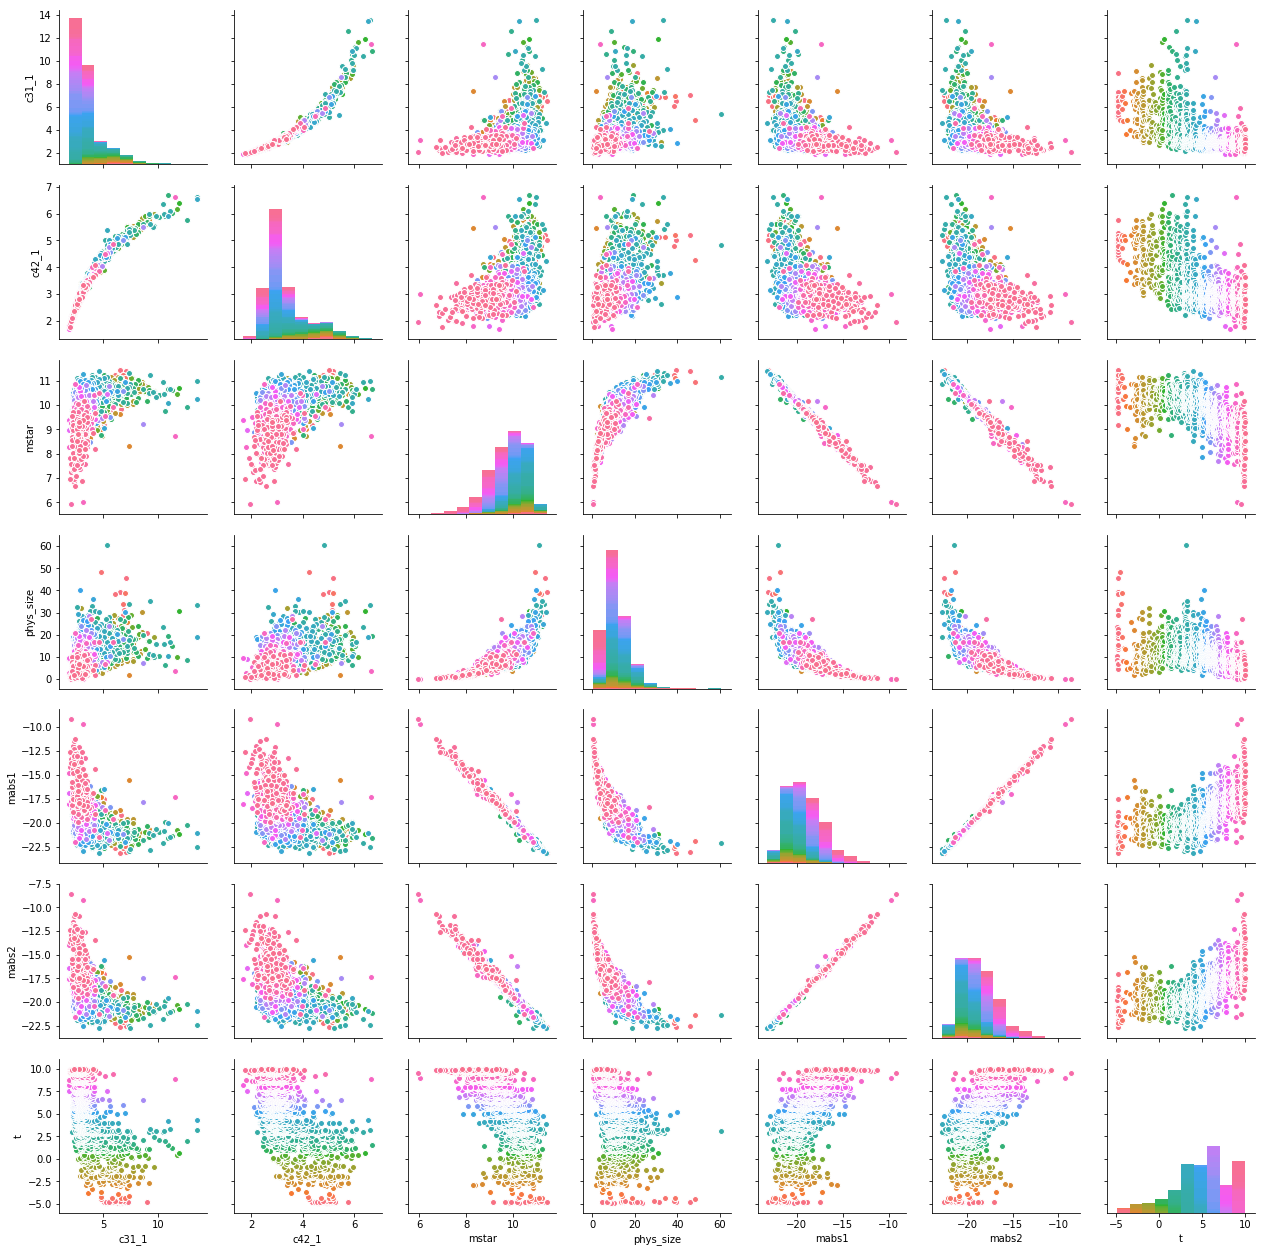

In [13]:
ax = sns.pairplot(df, hue='t')
ax._legend.remove()

### Prepare the actual dataframe which will be processed selecting only the `parameters` columns

In [14]:
df_params = df[parameters].copy()
df_params.describe()

,c31_1,c42_1,mstar,phys_size,mabs1,mabs2
count,1837.000000,1837.000000,1837.000000,1837.000000,1837.000000,1837.000000
mean,3.555723,3.297949,9.771949,11.108865,-19.108547,-18.678111
std,1.458724,0.814425,0.793912,6.079434,1.991846,2.002904
min,1.855000,1.695000,5.937000,0.184714,-23.200000,-22.762000
25%,2.755000,2.778000,9.278000,7.058402,-20.641000,-20.206000
50%,3.041000,3.037000,9.885000,10.226338,-19.403000,-18.976000
75%,3.608000,3.501000,10.377000,14.101213,-17.827000,-17.388000
max,13.544000,6.688000,11.448000,60.631647,-9.208000,-8.609000


1-$\sigma$ normalization and centering

In [15]:
df_norm = (df_params-df_params.mean())/df_params.std()
df_norm.head()

,c31_1,c42_1,mstar,phys_size,mabs1,mabs2
0,-0.134860,0.210026,0.254501,-0.469689,-0.273843,-0.283533
1,-1.115169,-1.835590,-1.860343,-1.392827,2.173635,2.333667
2,0.382716,0.629955,0.918302,0.537358,-0.888348,-0.868683
3,-0.636669,-0.762439,0.080678,-0.743961,-0.079551,-0.078331
6,0.539017,0.984807,1.396945,1.939825,-1.332158,-1.292568


In [16]:
df_norm.describe()

,c31_1,c42_1,mstar,phys_size,mabs1,mabs2
count,1.837000e+03,1.837000e+03,1.837000e+03,1.837000e+03,1.837000e+03,1.837000e+03
mean,1.708728e-15,-8.232512e-15,-1.960641e-14,1.764813e-15,-2.434555e-14,4.230451e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.165898e+00,-1.968199e+00,-4.830445e+00,-1.796903e+00,-2.054101e+00,-2.038984e+00
25%,-5.489206e-01,-6.384255e-01,-6.221707e-01,-6.662566e-01,-7.693631e-01,-7.628368e-01
50%,-3.528588e-01,-3.204095e-01,1.423976e-01,-1.451660e-01,-1.478291e-01,-1.487285e-01
75%,3.583718e-02,2.493179e-01,7.621135e-01,4.922083e-01,6.433966e-01,6.441202e-01
max,6.847271e+00,4.162510e+00,2.111129e+00,8.145953e+00,4.970538e+00,5.027256e+00


We will run PCA and t-SNE on `df_norm` and we will use the original data from `df`

# Run the PCA

In [17]:
pca = decomposition.TruncatedSVD(n_components=2)
fitted_pca = pca.fit_transform(df_norm)

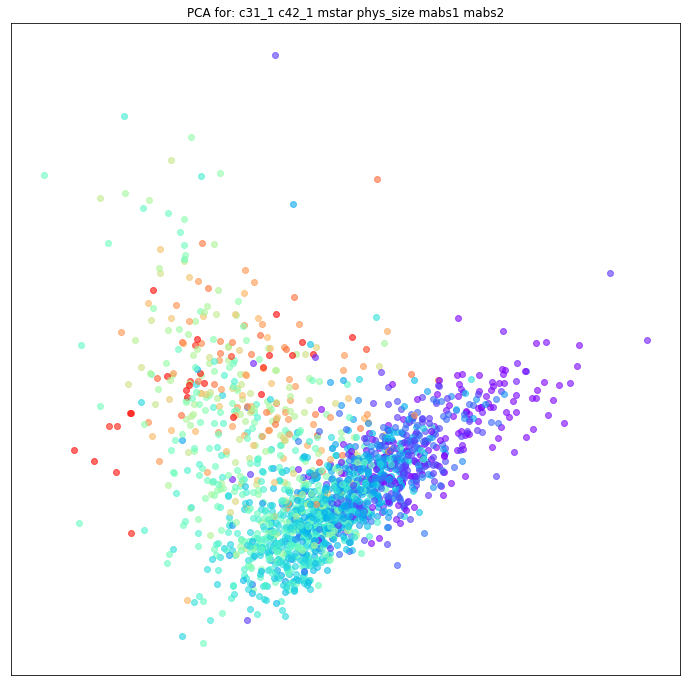

In [18]:
fig, ax = plot_embedding(fitted_pca, df.t, df_norm, "PCA for: " + " ".join(parameters), alpha=0.6, color=True)

This is quite bimodal! Elliptical and spiral galaxies (color code is red to blue respectively) are correctly clustered. 

You can print the following attributes to get an idea of different PCA output values

In [23]:
pca.explained_variance_

array([ 4.29393169,  1.33323542])

In [24]:
pca.singular_values_

array([ 88.8141459,  49.4889227])

In [25]:
pca.components_

array([[-0.3118372 , -0.33813831, -0.45811617, -0.39973395,  0.45834834,
         0.45681417],
       [ 0.65019992,  0.60548515, -0.23367179, -0.20769845,  0.23708828,
         0.23806678]])

# Run the t-SNE algorithm

We run t-SNE with different perplexity values and we noted that:
* Results are quite stable with different value of the hyperparameter (perplexity)
* there is always a cluster of red galaxies out of the main cluster of neighboring points

We decided to study further what are the characteristics of the galaxies inside this cluster of point which we call the _pocket_ 

In [34]:
def save_tsne(not_na_norm, labels, perpl_list, savefig=False):
    for perpl in perpl_list:
        print('doing tSNE for perplexity', perpl)
        tsne = manifold.TSNE(n_components=2, perplexity=perpl)
        res = tsne.fit_transform(not_na_norm)
        fig_tsne, ax_tsne = plot_embedding(res, labels, not_na_norm, title="tSNE for: " + " ".join(parameters) + " perplexity={}".format(perpl), alpha=0.6)
        if savefig:
            fig_tsne.savefig("tsne_{}_p{}".format(len(parameters), perpl))

doing tSNE for perplexity 5
doing tSNE for perplexity 15
doing tSNE for perplexity 30
doing tSNE for perplexity 40
doing tSNE for perplexity 50


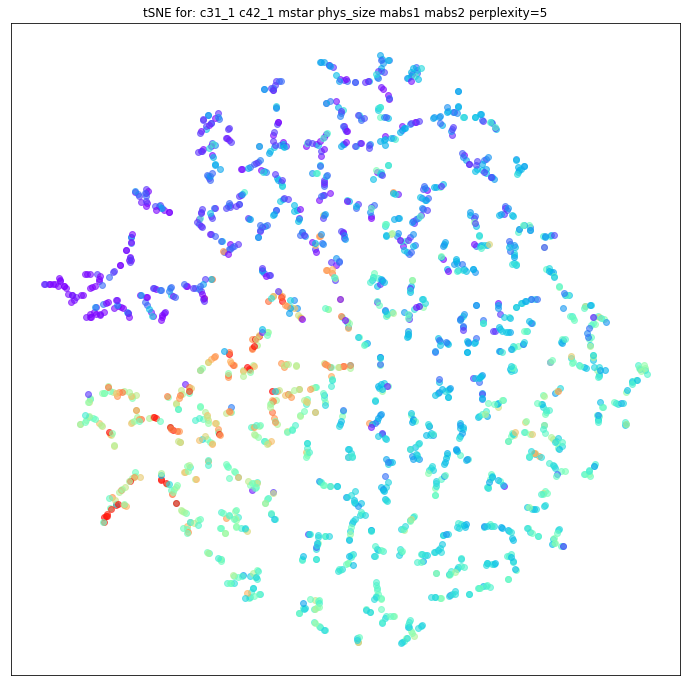

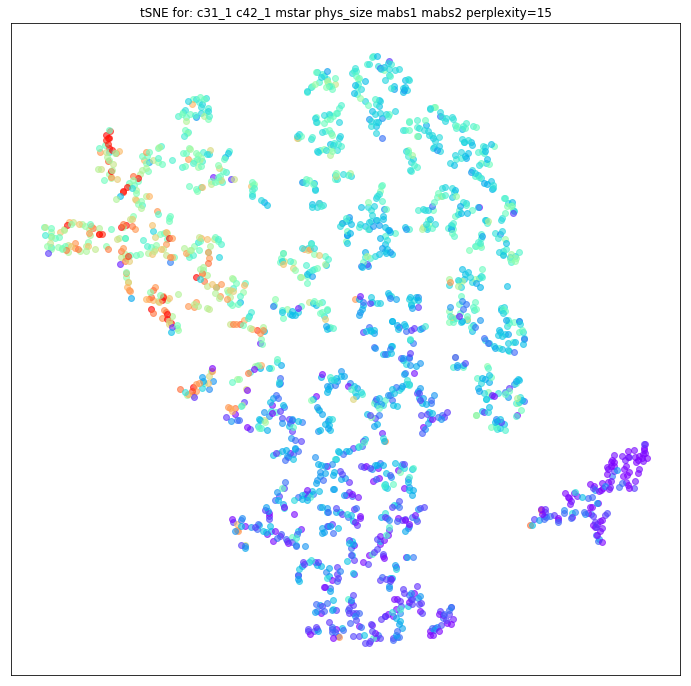

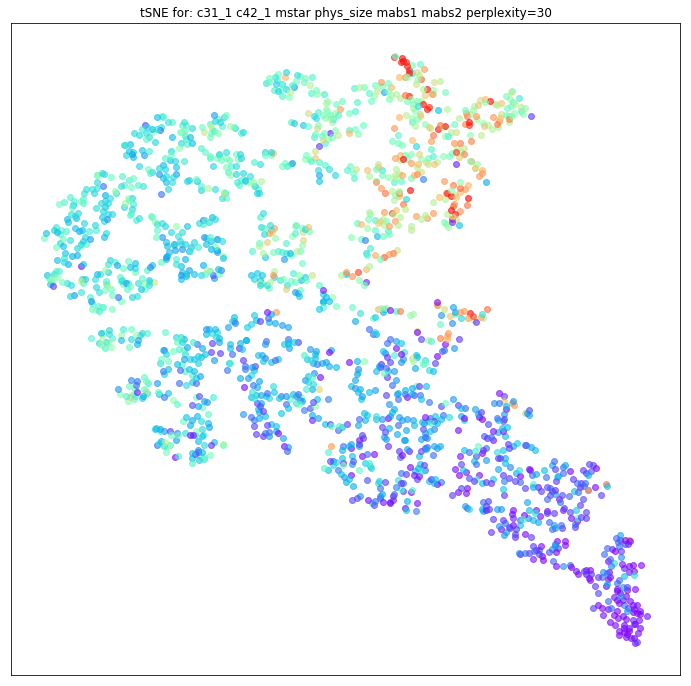

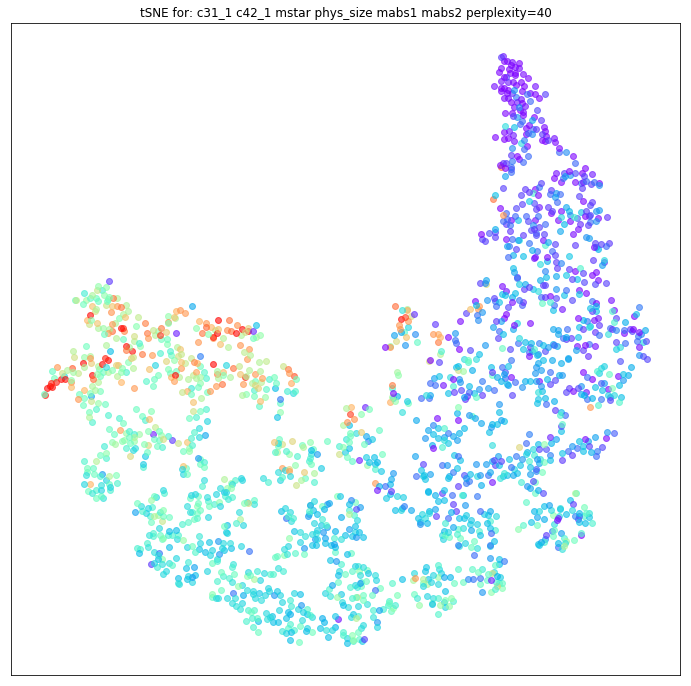

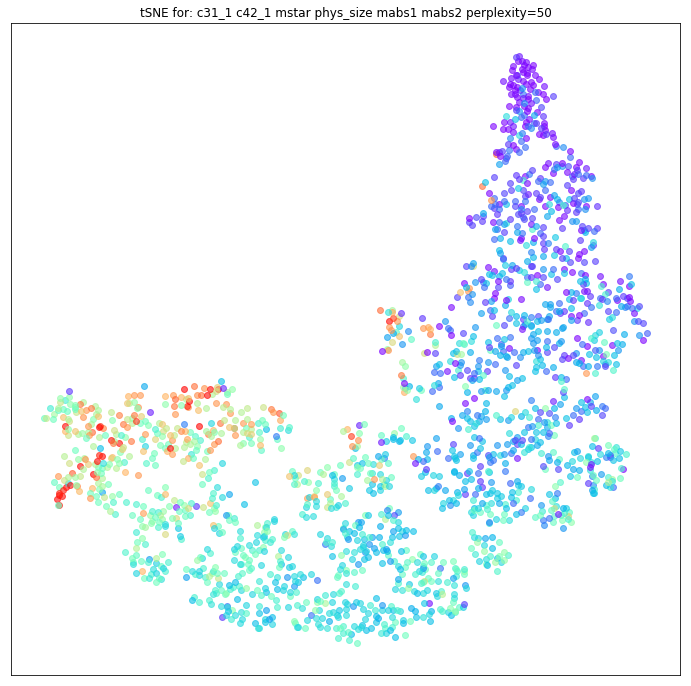

In [33]:
save_tsne(df_norm, df.t, [5, 15, 30, 40, 50])

# Study the "pocket"

In [35]:
tsne = sklearn.manifold.TSNE()
tsne = manifold.TSNE(n_components=2, perplexity=40, random_state=5) # Use a random_state for the sake of reproducibility
res = tsne.fit_transform(df_norm)

Add to the dataframe the min-max normalized coordinates of the points in the embedded space

In [36]:
r_min, r_max = np.min(res, 0), np.max(res, 0)
res_norm = (res - r_min) / (r_max - r_min)
df['x']=res_norm[:,0]
df['y']=res_norm[:,1]

check if dimensions matches

In [37]:
res.shape[0], len(df)

(1837, 1837)

In [49]:
# Switch on interactivity for this plot so you can see the coordinates of the points
%matplotlib notebook

<IPython.core.display.Javascript object>


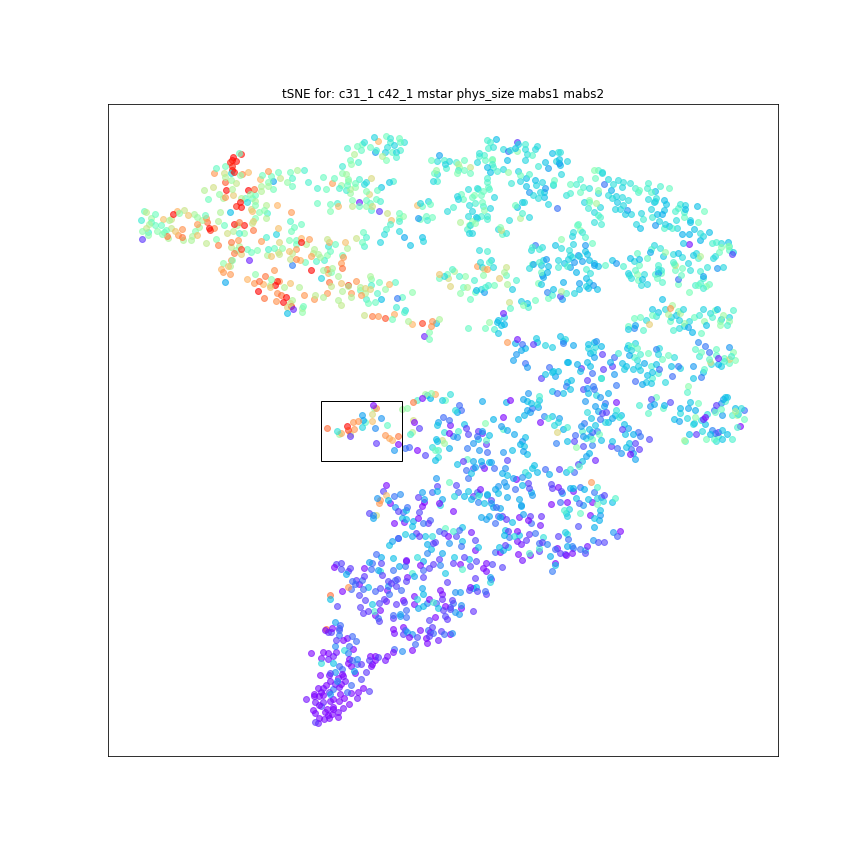

In [50]:
fig_tsne, ax_tsne = plot_embedding(res, df.t, df_norm, title="tSNE for: " + " ".join(parameters), alpha=0.6)

Elliptical and spiral galaxies (color code is red to blue respectively) are correctly clustered. We want to further investigate the little pocket of red points you can see around the center of the plot.

Choose a rectangular region (defined by its vertexes) which you want to investigate further. Note that the t-SNE is ramdom initialized and produces a different output every time it is run if you don't include the `random_state` option

In [51]:
x_min, x_max = 0.2977, 0.432115
y_min, y_max = 0.446481, 0.548681

In [52]:
from matplotlib.patches import Rectangle
rect = Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, fill=False)
ax_tsne.add_patch(rect)

In [53]:
pocket = (x_min<df.x) & (df.x < x_max) & (y_min<df.y) & (df.y < y_max)

In [54]:
print("In the pocket there are {} points".format(pocket.sum()))

In the pocket there are 30 points


In [55]:
filtered=df[pocket]

In [56]:
filtered

,object,c31_1,c42_1,mstar,phys_size,mabs1,mabs2,t,x,y
29,NGC3077,4.063,3.816,9.356,3.999074,-18.057,-17.620,7.2,0.386983,0.502908
126,NGC4312,4.246,3.911,9.670,7.404754,-18.827,-18.382,2.0,0.386223,0.536992
236,ESO358-025,3.652,3.540,9.370,5.513861,-18.136,-17.723,-2.6,0.425696,0.489305
241,ESO359-003,4.824,4.002,8.758,5.728219,-16.580,-16.154,1.4,0.328072,0.492355
451,NGC0855,5.112,4.372,9.165,5.056878,-17.515,-17.044,-4.8,0.341445,0.507296
492,ESO575-061,4.058,3.954,10.175,8.439401,-17.827,-16.159,7.0,0.397097,0.520845
609,NGC0014,3.556,3.386,9.299,5.721577,-17.882,-17.427,9.9,0.425642,0.476206
629,UGC04393,4.470,4.014,9.371,5.919502,-18.039,-17.573,3.5,0.370311,0.513097
674,NGC1036,4.436,3.896,8.994,3.111340,-17.198,-16.786,0.0,0.346324,0.493748
703,IC2085,3.851,3.545,9.277,5.846985,-17.899,-17.484,-1.2,0.415423,0.483284


<IPython.core.display.Javascript object>


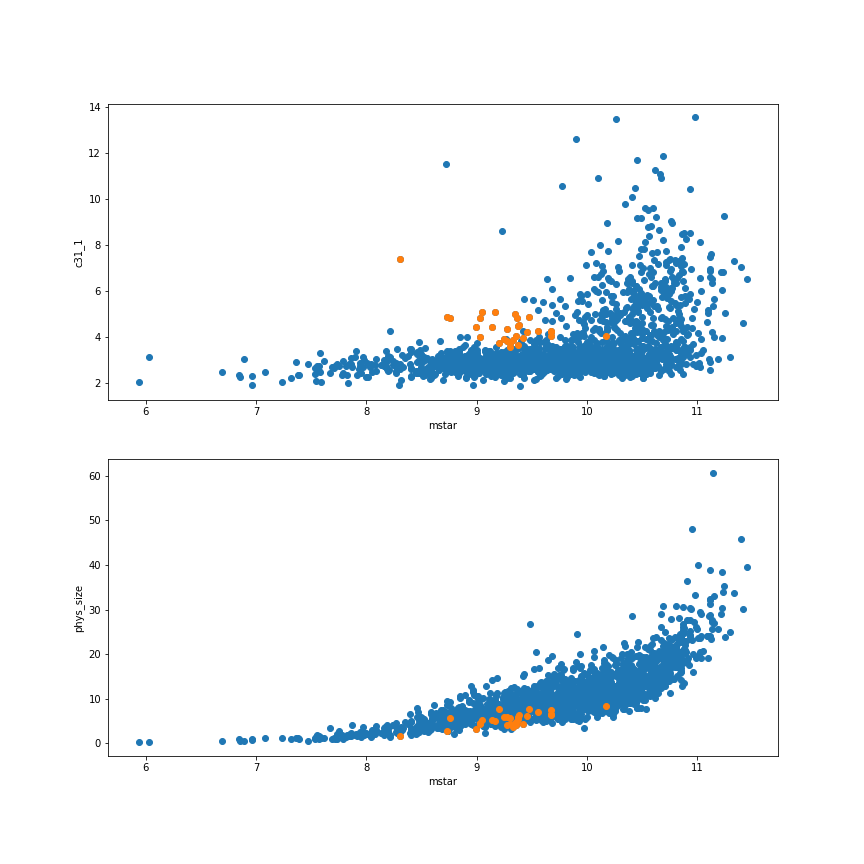

Text(0,0.5,'phys_size')

In [57]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,12))
# mstar - concentration
ax1.scatter(df.mstar,df.c31_1)
ax1.scatter(df.loc[pocket, "mstar"],df.loc[pocket,"c31_1"])
ax1.set_xlabel("mstar")
ax1.set_ylabel("c31_1")
# mstar - phys_size
ax2.scatter(df.mstar,df.phys_size)
ax2.scatter(df.loc[pocket, "mstar"],df.loc[pocket,"phys_size"])
ax2.set_xlabel("mstar")
ax2.set_ylabel("phys_size")

<IPython.core.display.Javascript object>


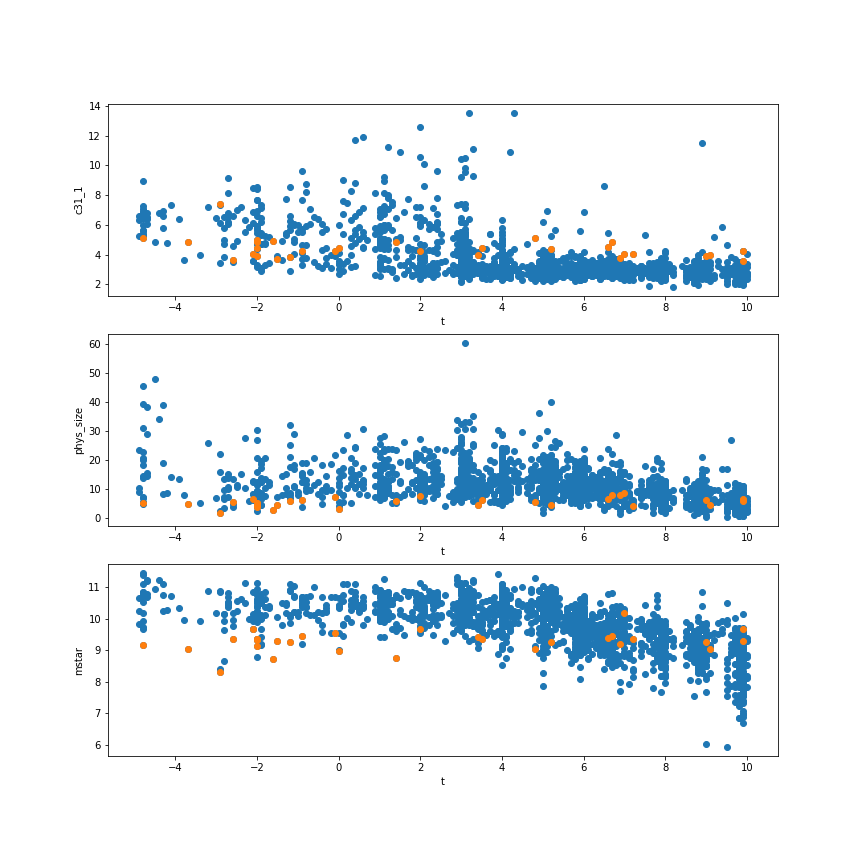

Text(0,0.5,'mstar')

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,12))
# t - concentration
ax1.scatter(df.t,df.c31_1)
ax1.scatter(df.loc[pocket, "t"],df.loc[pocket,"c31_1"])
ax1.set_xlabel("t")
ax1.set_ylabel("c31_1")
# t - phys_size
ax2.scatter(df.t,df.phys_size)
ax2.scatter(df.loc[pocket, "t"],df.loc[pocket,"phys_size"])
ax2.set_xlabel("t")
ax2.set_ylabel("phys_size")
# t - mstar
ax3.scatter(df.t,df.mstar)
ax3.scatter(df.loc[pocket, "t"],df.loc[pocket,"mstar"])
ax3.set_xlabel("t")
ax3.set_ylabel("mstar")

## Bottom line:  galaxies in the pocket seems to be highly concentrated and with low mass

Further investigation is needed. This demonstrates how to visualize galactic tabular data and use the t-SNE 